# SETUP

In [1]:
import numpy as np
import datetime
import matplotlib.pyplot as plt 
from matplotlib import cm
import shutil
from datetime import datetime, timedelta
import glob
import datetime as dt
from os import path
import cartopy.crs as ccrs
import fsspec
import sys
from datetime import timezone
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# check scikit-learn version
import sklearn
from numpy import mean
from numpy import std
from sklearn import svm
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets, linear_model
from sklearn.utils import shuffle
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import os, sys
from sklearn import preprocessing
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import csv



In [2]:


class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [3]:
pd.set_option("display.precision", 8)

In [4]:
# Function to randomly sample 1 out of every 4 entries in each group
def sample_group(group):
    return group.sample(1)



In [5]:
def plot_importance(mean_importances,title,plot_folder):
    df = pd.DataFrame(mean_importances.sort_values(by=['Mean Importance'], ascending=False)["Mean Importance"].values)
    df.set_index(mean_importances.sort_values(by=['Mean Importance'], ascending=False).Feature.values,inplace=True)
    #plt.figure(figsize=(10, 5), dpi= 300)
    df.plot(kind='bar', stacked=True,legend=False,title=title, ylabel="relative importance")
    plt.tight_layout()
    plt.savefig(plot_folder+title+".pdf")
    plt.savefig(plot_folder+title+".png")
    plt.show()
    return

In [6]:
def run_two_rf_B(data,group_by,target,vars_2_rm_A,vars_2_rm_B,trainvalsplit=.2):
    data_sampled = data.groupby(group_by).apply(sample_group).reset_index(drop=True)
    data_features=data_sampled.drop(columns=vars_2_rm_A)
    feature_list=data_features.columns
    data_labels=data_sampled[target]
    data_features_shuffled,data_labels_shuffled=shuffle(data_features,data_labels,)
    X = data_features_shuffled.values
    y= data_labels_shuffled.values

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=trainvalsplit)
    Z_train=np.repeat(1,np.shape(y_train)[0])
    Z_train=Z_train.reshape(np.shape(y_train)[0],1)
    Z_test=np.repeat(1,np.shape(y_test)[0])
    Z_test=Z_test.reshape(np.shape(y_test)[0],1)

    model_A=RandomForestClassifier(n_estimators=500)
    model_A.fit(X_train,y_train)
    pred_train_A = model_A.predict(X_train)
    pred_test_A = model_A.predict(X_test)
    acc_A=accuracy_score(pred_test_A, y_test)
    prec_A=precision_score(pred_test_A, y_test)
    rec_A=recall_score(pred_test_A, y_test)
    importances = list(model_A.feature_importances_)
    feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    df_A = pd.DataFrame(feature_importances,columns=["feature","value"])
    df_A = pd.DataFrame(df_A.value.values, index=df_A.feature, columns=['Importance'])

    data_features=data_sampled.drop(columns=vars_2_rm_B)
    feature_list=data_features.columns
    data_labels=data_sampled[target]
    data_features_shuffled,data_labels_shuffled=shuffle(data_features,data_labels,)
    X = data_features_shuffled.values
    y= data_labels_shuffled.values

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=trainvalsplit)
    Z_train=np.repeat(1,np.shape(y_train)[0])
    Z_train=Z_train.reshape(np.shape(y_train)[0],1)
    Z_test=np.repeat(1,np.shape(y_test)[0])
    Z_test=Z_test.reshape(np.shape(y_test)[0],1)
    X_train_pd=data_features_shuffled.iloc[:np.shape(X_train)[0],:]
    y_train_pd=data_labels_shuffled.iloc[:np.shape(X_train)[0]]
    X_test_pd=data_features_shuffled.iloc[np.shape(X_train)[0]:,:]
    y_test_pd=data_labels_shuffled.iloc[np.shape(X_train)[0]:]


    model_B=RandomForestClassifier(n_estimators=500)
    model_B.fit(X_train,y_train)
    importances = list(model_B.feature_importances_)
    pred_train_B = model_B.predict(X_train)
    pred_test_B = model_B.predict(X_test)
    acc_B=accuracy_score(pred_test_B, y_test)
    prec_B=precision_score(pred_test_B, y_test)
    rec_B=recall_score(pred_test_B, y_test)
    feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    df_B = pd.DataFrame(feature_importances,columns=["feature","value"])
    df_B = pd.DataFrame(df_B.value.values, index=df_B.feature, columns=['Importance'])

    return df_A,df_B,acc_A,acc_B,prec_A,prec_B,rec_A,rec_B

# Author

* Author: Martin Wegmann

* Contact: martin.wegmann@unibe.ch

# Goal

There are two dependent, dichotomous variables, called: mdr and nwt. We want to model each one of them with random forest. We will loop 10000 times to get a random distribution of independent data sets.

# Folder

In [7]:
input_folder="/Volumes/SPARK/veronique_work_folder/"
plot_folder=input_folder
output_folder=input_folder

# Data

# environment data set with weather

In [8]:
data=pd.read_csv(input_folder+"MICenvironment_weather_v7_modified.csv",sep=",")

In [9]:
data

,FarmID,Datum,mdr,Item8_Constantgroup,Item12_Equip_preweaned,Item1_Milk_yield,Item11_Equip_feed_manure,Item10_Wastemilk,Item17_Dogs,Item9_Calfdiet,...,Item29_Ave_temp,Item30_Max_temp,Item31_Min_temp,Item32_Dev_temp,Item33_Ave_precip,Item34_Dev_precip,Item24_AMU_systemic,Item25_AMU_calves,Item5_Calfmovedafterbirth,Item7_Groupsize
0,32,1042022,1,0,0,0,0,0,0.0,0,...,2.82088610,15.0408920,-3.5701003,2.01992770,3.3168111,0.58523589,1,1,0,1
1,32,1042022,1,0,0,0,0,0,0.0,0,...,2.82088610,15.0408920,-3.5701003,2.01992770,3.3168111,0.58523589,1,1,0,1
2,32,1042022,1,0,0,0,0,0,0.0,0,...,2.82088610,15.0408920,-3.5701003,2.01992770,3.3168111,0.58523589,1,1,0,1
3,32,1042022,1,0,0,0,0,0,0.0,0,...,2.82088610,15.0408920,-3.5701003,2.01992770,3.3168111,0.58523589,1,1,0,1
4,33,1042022,0,1,0,1,0,0,1.0,1,...,1.47134130,14.6019380,-7.6458225,1.45420380,3.6306005,0.34906447,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,13,2062023,0,0,0,0,0,1,1.0,1,...,1.28320670,10.6369380,-11.1180280,1.01424480,1.8129220,-0.08087495,1,1,1,1
773,20,2062023,0,1,0,0,0,1,1.0,1,...,-0.40751234,9.3809729,-11.9477640,0.05851183,2.8592157,0.21661212,1,1,0,0
774,20,2062023,0,1,0,0,0,1,1.0,1,...,-0.40751234,9.3809729,-11.9477640,0.05851183,2.8592157,0.21661212,1,1,0,0
775,20,2062023,1,1,0,0,0,1,1.0,1,...,-0.40751234,9.3809729,-11.9477640,0.05851183,2.8592157,0.21661212,1,1,0,0


In [10]:
data.columns

Index(['FarmID', 'Datum', 'mdr', 'Item8_Constantgroup',
       'Item12_Equip_preweaned', 'Item1_Milk_yield',
       'Item11_Equip_feed_manure', 'Item10_Wastemilk', 'Item17_Dogs',
       'Item9_Calfdiet', 'Item18_Rodent_control', 'Item19_Bird_control',
       'Item2_Milk_SCC', 'Item3_Stall', 'Item6_Contact_feces',
       'Item21_Pneumonia30d_weaning', 'Item15_2_New_animals_nbfarms', 'nwt',
       'Item29_Ave_temp', 'Item30_Max_temp', 'Item31_Min_temp',
       'Item32_Dev_temp', 'Item33_Ave_precip', 'Item34_Dev_precip',
       'Item24_AMU_systemic', 'Item25_AMU_calves', 'Item5_Calfmovedafterbirth',
       'Item7_Groupsize'],
      dtype='object')

## model nwt

In [22]:

items_2_remove_A=['Datum', 'mdr','nwt']
items_2_remove_B=['FarmID','Datum', 'mdr','nwt']


df_11_list=[]
df_22_list=[]

acc_A_list=[]
acc_B_list=[]

prec_A_list=[]
prec_B_list=[]

rec_A_list=[]
rec_B_list=[]
for i in range(10000):
    print(i)
    with HiddenPrints():
        df_A,df_B,acc_A,acc_B,prec_A,prec_B,rec_A,rec_B=run_two_rf_B(data,group_by='Datum',target="nwt",vars_2_rm_A=items_2_remove_A,vars_2_rm_B=items_2_remove_B,trainvalsplit=.2)
    df_11_list.append(df_A)
    df_22_list.append(df_B)
    acc_A_list.append(acc_A)
    acc_B_list.append(acc_B)
    prec_A_list.append(prec_A)
    prec_B_list.append(prec_B)
    rec_A_list.append(rec_A)
    rec_B_list.append(rec_B)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [23]:
print(np.mean(acc_A_list))

0.5629772727272727


In [24]:
print(np.std(acc_A_list))

0.10500186686652073


In [25]:
print(np.mean(acc_B_list))

0.5674272727272726


In [26]:
print(np.std(acc_B_list))

0.1056026041345572


### plot importances

In [27]:
all_importances = pd.concat(df_11_list, axis=1)
mean_importances = all_importances_11.mean(axis=1)
mean_importances_df = mean_importances_11.reset_index()
mean_importances_df.columns = ['Feature', 'Mean Importance']
mean_importances_df.to_csv(output_folder+"mean_importances_env_nwt_with_weather_with_farmid.csv")

,Feature,Mean Importance
6,Item32_Dev_temp,0.10
2,Item33_Ave_precip,0.10
5,Item34_Dev_precip,0.09
0,Item31_Min_temp,0.09
1,Item30_Max_temp,0.09
3,Item29_Ave_temp,0.09
4,FarmID,0.09
7,Item15_2_New_animals_nbfarms,0.04
10,Item7_Groupsize,0.03
8,Item2_Milk_SCC,0.02


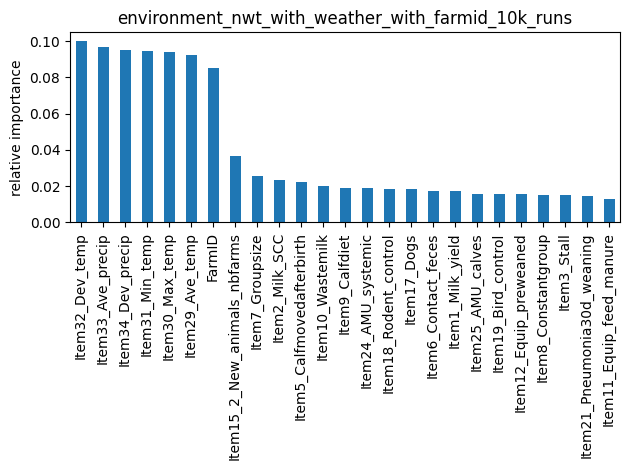

In [28]:
plot_importance(mean_importances=mean_importances_df,title="environment_nwt_with_weather_with_farmid_10k_runs",plot_folder=plot_folder)

In [29]:
all_importances = pd.concat(df_22_list, axis=1)
mean_importances = all_importances_22.mean(axis=1)
mean_importances_df = mean_importances_22.reset_index()
mean_importances_df.columns = ['Feature', 'Mean Importance']
mean_importances_df.to_csv(output_folder+"mean_importances_env_nwt_with_weather_without_farmid.csv")

,Feature,Mean Importance
5,Item32_Dev_temp,0.10
0,Item33_Ave_precip,0.10
2,Item34_Dev_precip,0.10
1,Item31_Min_temp,0.10
4,Item30_Max_temp,0.10
3,Item29_Ave_temp,0.10
6,Item15_2_New_animals_nbfarms,0.04
10,Item7_Groupsize,0.03
7,Item2_Milk_SCC,0.03
16,Item5_Calfmovedafterbirth,0.03


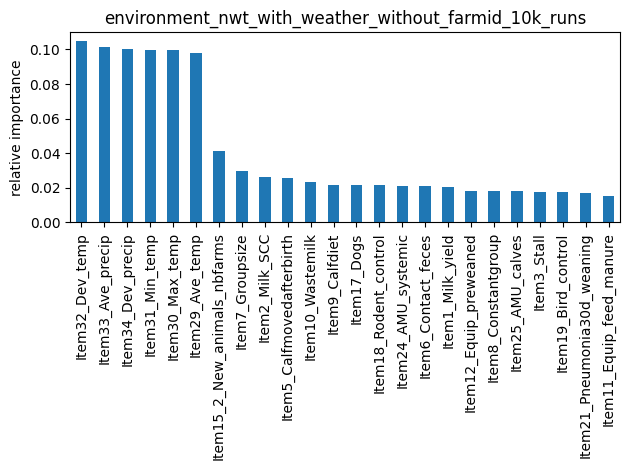

In [30]:
plot_importance(mean_importances=mean_importances_df,title="environment_nwt_with_weather_without_farmid_10k_runs",plot_folder=plot_folder)


### plot skill metrics

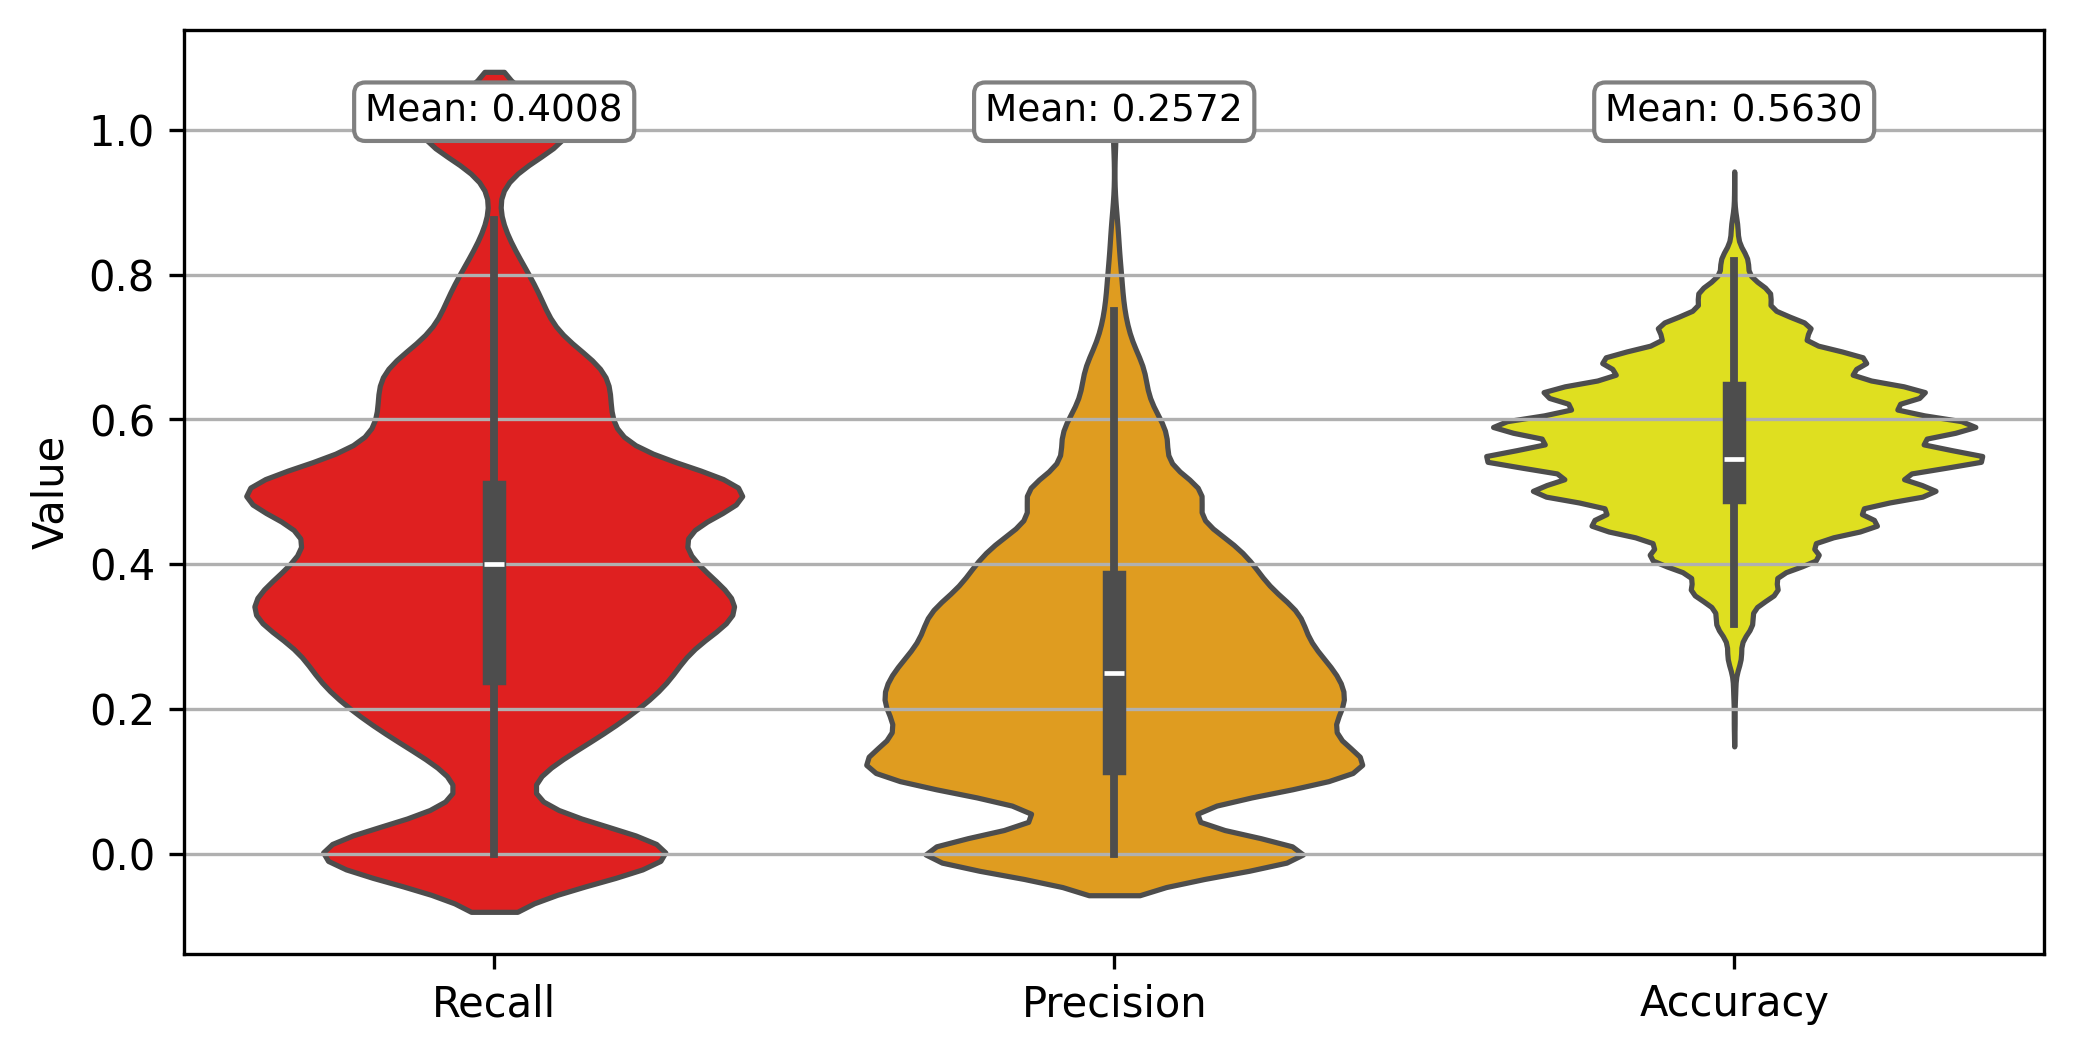

In [31]:

palette = {"Recall": "red", "Precision": "orange", "Accuracy": "yellow"}
# Example lists (replace these with your actual data)
value_list_1 = rec_A_list
value_list_2 = prec_A_list
value_list_3 = acc_A_list

# Labels for each list (will appear on x-axis)
labels = ["Recall", "Precision", "Accuracy"]

# Combine all data into one DataFrame
df = pd.DataFrame({
    'Value': value_list_1 + value_list_2 + value_list_3,
    'Group': [labels[0]] * len(value_list_1) +
             [labels[1]] * len(value_list_2) +
             [labels[2]] * len(value_list_3)
})

# Calculate means
means = df.groupby('Group')['Value'].mean()

# Create a high-resolution figure
plt.figure(dpi=300, figsize=(8, 4))

# Create the violin plot
ax = sns.violinplot(x='Group', y='Value', data=df, inner='box', palette=palette)

# Add mean as text above each violin
for i, label in enumerate(labels):
    mean_val = means[label]
    ax.text(
        i, df['Value'].max(), f"Mean: {mean_val:.4f}",
        ha='center', va='bottom', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
    )

# Customize plot
plt.grid(True, axis='y')
plt.xlabel('')
plt.ylabel('Value')

# Save the figure
plt.savefig(plot_folder + "mean_metrics_env_nwt_with_weather_with_farmid.png", format='png', dpi=300, bbox_inches='tight')
plt.savefig(plot_folder + "mean_metrics_env_nwt_with_weather_with_farmid.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


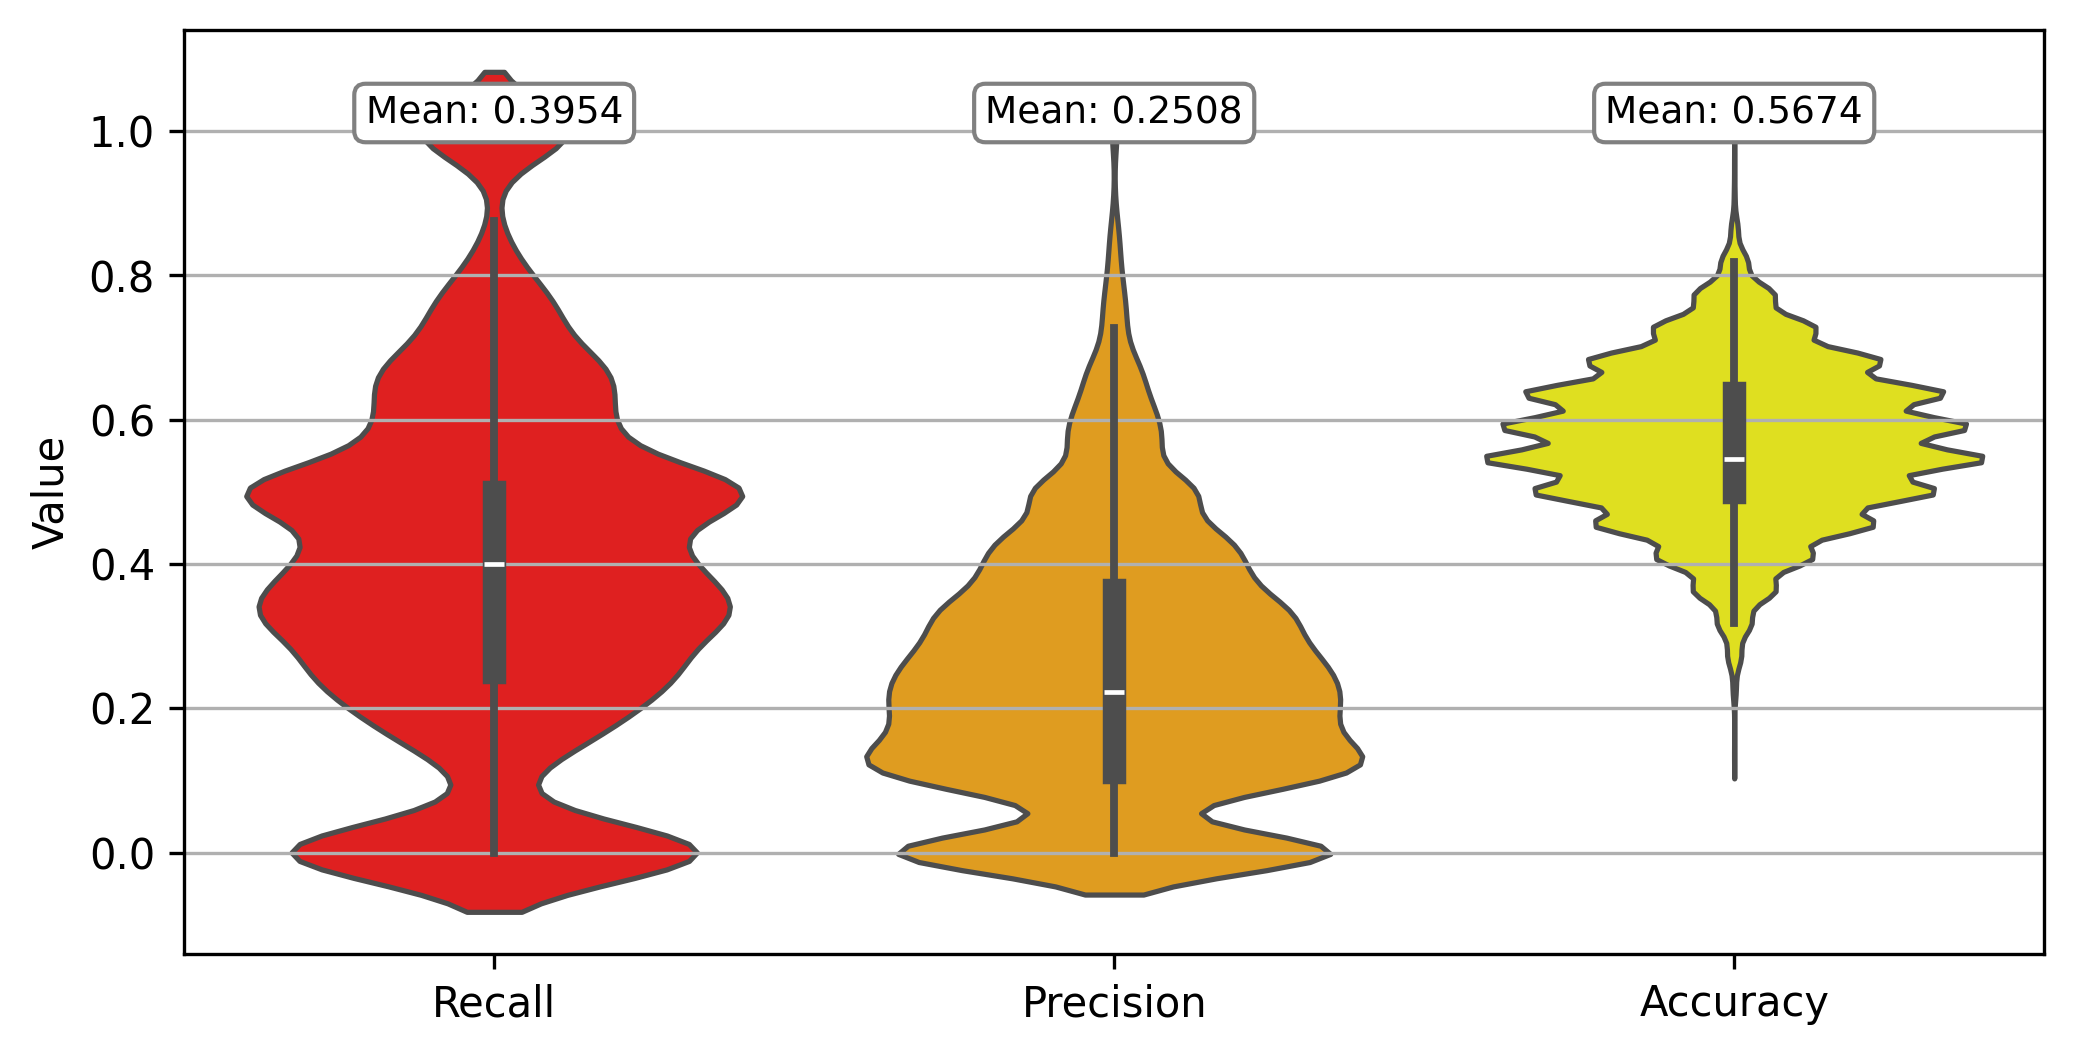

In [32]:

palette = {"Recall": "red", "Precision": "orange", "Accuracy": "yellow"}
# Example lists (replace these with your actual data)
value_list_1 = rec_B_list
value_list_2 = prec_B_list
value_list_3 = acc_B_list

# Labels for each list (will appear on x-axis)
labels = ["Recall", "Precision", "Accuracy"]

# Combine all data into one DataFrame
df = pd.DataFrame({
    'Value': value_list_1 + value_list_2 + value_list_3,
    'Group': [labels[0]] * len(value_list_1) +
             [labels[1]] * len(value_list_2) +
             [labels[2]] * len(value_list_3)
})

# Calculate means
means = df.groupby('Group')['Value'].mean()

# Create a high-resolution figure
plt.figure(dpi=300, figsize=(8, 4))

# Create the violin plot
ax = sns.violinplot(x='Group', y='Value', data=df, inner='box', palette=palette)

# Add mean as text above each violin
for i, label in enumerate(labels):
    mean_val = means[label]
    ax.text(
        i, df['Value'].max(), f"Mean: {mean_val:.4f}",
        ha='center', va='bottom', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
    )

# Customize plot
plt.grid(True, axis='y')
plt.xlabel('')
plt.ylabel('Value')

# Save the figure
plt.savefig(plot_folder + "mean_metrics_env_nwt_with_weather_without_farmid.png", format='png', dpi=300, bbox_inches='tight')
plt.savefig(plot_folder + "mean_metrics_env_nwt_with_weather_without_farmid.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


## model mdr

In [32]:

items_2_remove_A=['Datum', 'mdr','nwt']
items_2_remove_B=['FarmID','Datum', 'mdr','nwt']


df_mdr_A_list=[]
df_mdr_B_list=[]

acc_mdr_A_list=[]
acc_mdr_B_list=[]

prec_mdr_mdr_A_list=[]
prec_mdr_mdr_B_list=[]

rec_mdr_A_list=[]
rec_mdr_B_list=[]
for i in range(10000):
    print(i)
    with HiddenPrints():
        df_A,df_B,acc_mdr_A,acc_mdr_B,prec_mdr_mdr_A,prec_mdr_mdr_B,rec_mdr_A,rec_mdr_B=run_two_rf_B(data,group_by='Datum',target="mdr",vars_2_rm_A=items_2_remove_A,vars_2_rm_B=items_2_remove_B,trainvalsplit=.2)
    df_mdr_A_list.append(df_A)
    df_mdr_B_list.append(df_B)
    acc_mdr_A_list.append(acc_mdr_A)
    acc_mdr_B_list.append(acc_mdr_B)
    prec_mdr_mdr_A_list.append(prec_mdr_mdr_A)
    prec_mdr_mdr_B_list.append(prec_mdr_mdr_B)
    rec_mdr_A_list.append(rec_mdr_A)
    rec_mdr_B_list.append(rec_mdr_B)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [33]:
print(np.mean(acc_mdr_A_list))

0.7261136363636363


In [34]:
print(np.mean(acc_mdr_B_list))

0.7320681818181819


### plot importances

In [35]:
all_importances_mdr= pd.concat(df_mdr_A_list, axis=1)
mean_importances_mdr= all_importances_mdr_A.mean(axis=1)
mean_importances_df_mdr = mean_importances_mdr_A.reset_index()
mean_importances_df_mdr.columns = ['Feature', 'Mean Importance']
mean_importances_df_mdr.to_csv(output_folder+"mean_importances_env_mdr_with_weather_with_farmid.csv")

,Feature,Mean Importance
2,Item32_Dev_temp,0.11
0,Item31_Min_temp,0.10
5,Item34_Dev_precip,0.09
1,Item33_Ave_precip,0.09
4,Item30_Max_temp,0.09
3,Item29_Ave_temp,0.09
6,FarmID,0.08
8,Item15_2_New_animals_nbfarms,0.04
9,Item2_Milk_SCC,0.03
12,Item17_Dogs,0.02


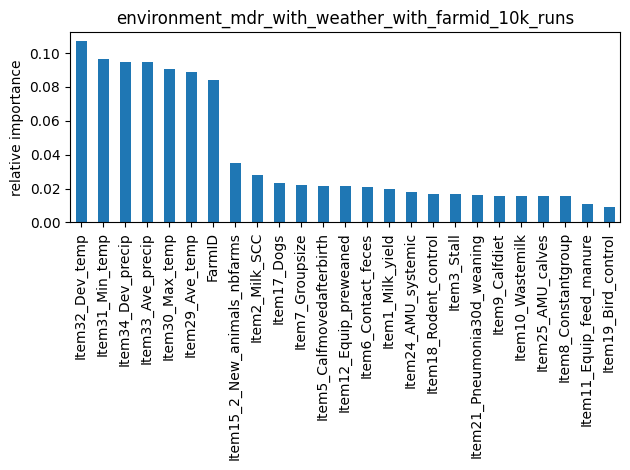

In [36]:
plot_importance(mean_importances=mean_importances_df_mdr,title="environment_mdr_with_weather_with_farmid_10k_runs",plot_folder=plot_folder)

In [37]:
all_importances_mdr = pd.concat(df_mdr_B_list, axis=1)
mean_importances_mdr = all_importances_mdr_B.mean(axis=1)
mean_importances_df_mdr = mean_importances_mdr_B.reset_index()
mean_importances_df_mdr.columns = ['Feature', 'Mean Importance']
mean_importances_df_mdr.to_csv(output_folder+"mean_importances_env_mdr_with_weather_without_farmid.csv")


,Feature,Mean Importance
0,Item32_Dev_temp,0.11
3,Item31_Min_temp,0.10
1,Item34_Dev_precip,0.10
2,Item33_Ave_precip,0.10
4,Item30_Max_temp,0.10
5,Item29_Ave_temp,0.10
7,Item15_2_New_animals_nbfarms,0.04
6,Item2_Milk_SCC,0.03
18,Item17_Dogs,0.03
8,Item7_Groupsize,0.03


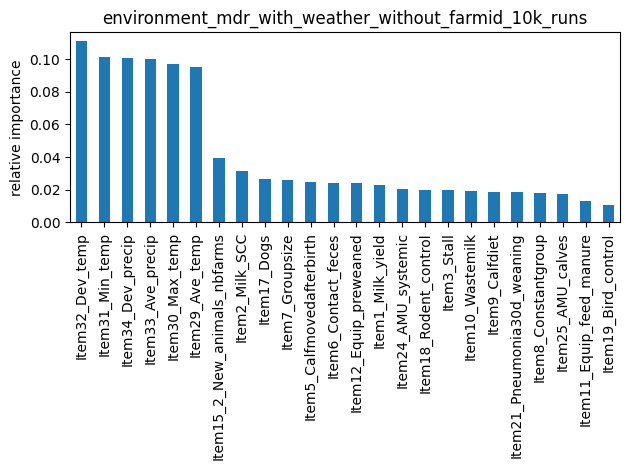

In [38]:
plot_importance(mean_importances=mean_importances_df_mdr,title="environment_mdr_with_weather_without_farmid_10k_runs",plot_folder=plot_folder)


### plot skill metrics

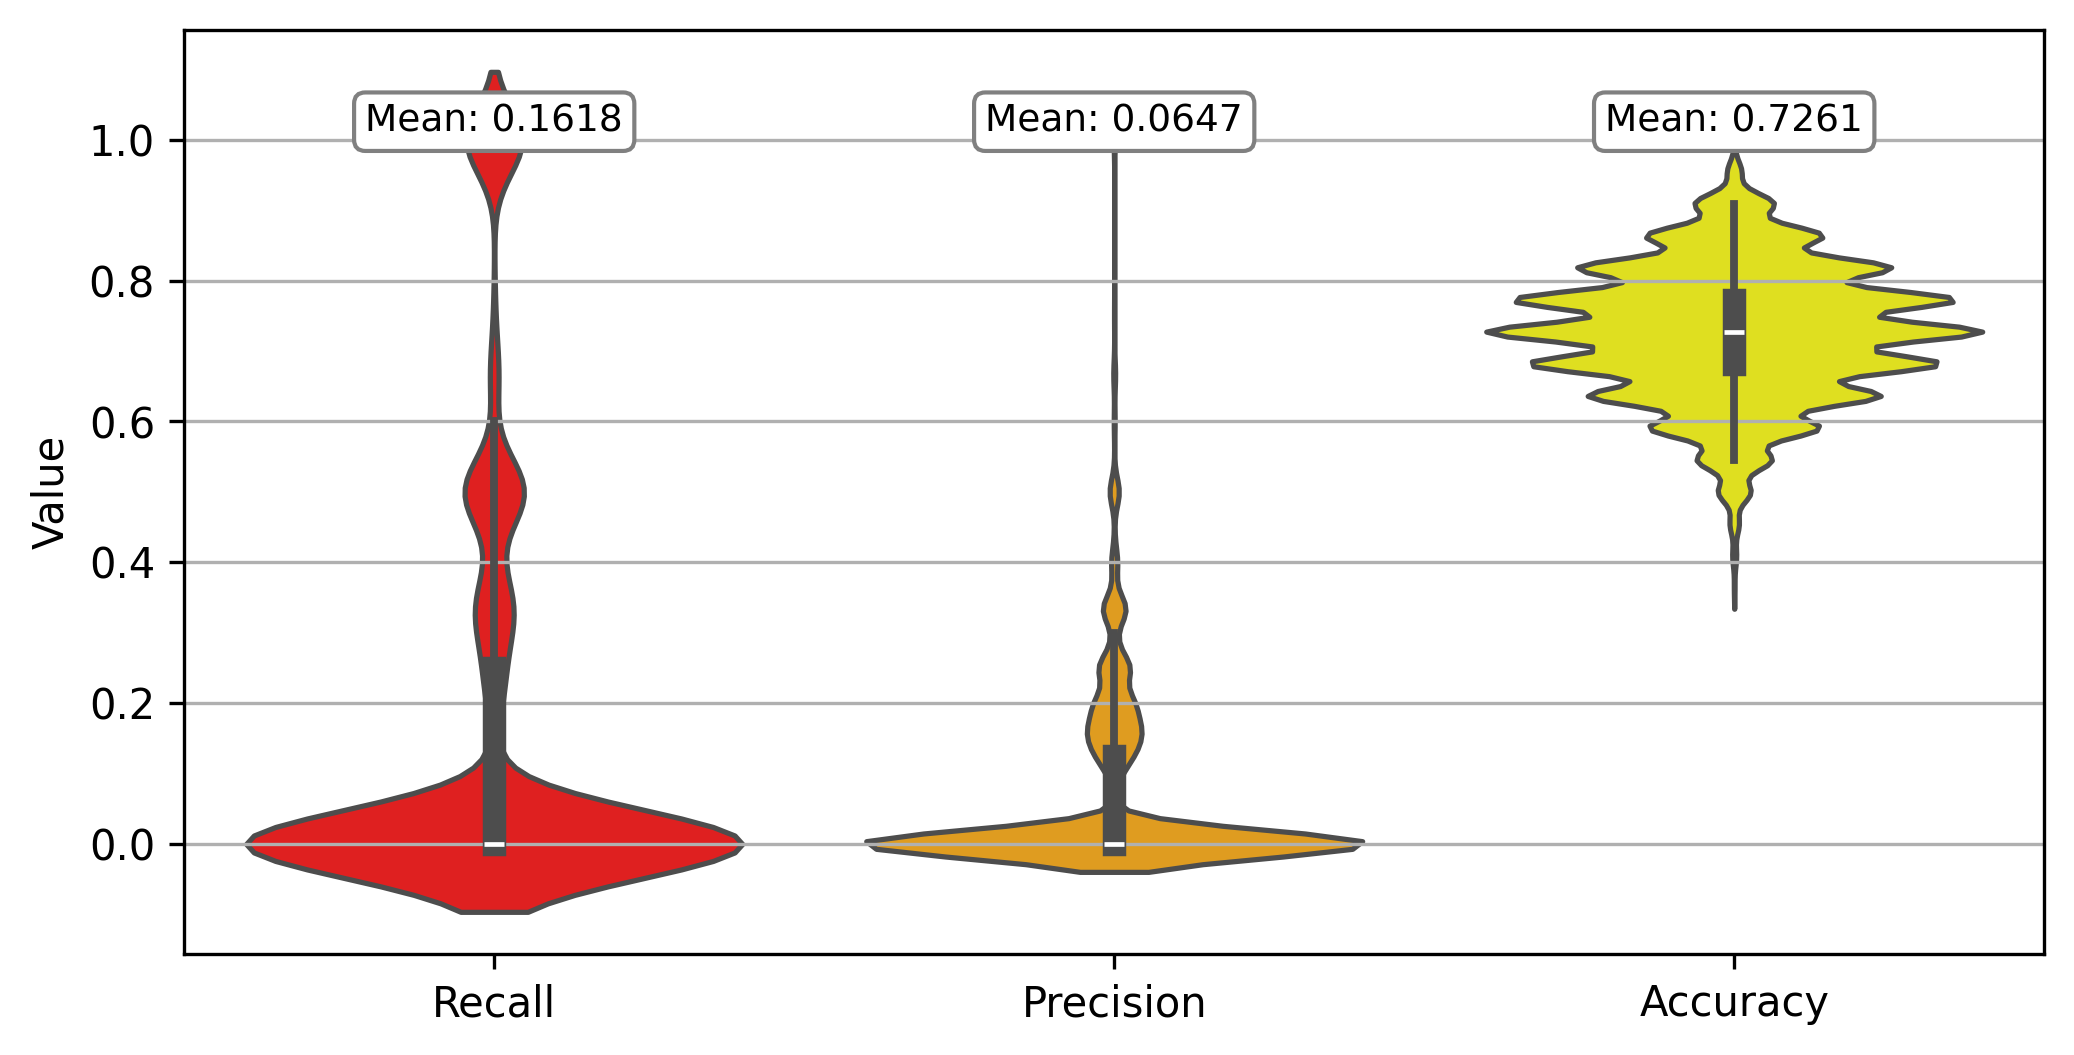

In [39]:

palette = {"Recall": "red", "Precision": "orange", "Accuracy": "yellow"}
# Example lists (replace these with your actual data)
value_list_1 = rec_mdr_A_list
value_list_2 = prec_mdr_mdr_A_list
value_list_3 = acc_mdr_A_list

# Labels for each list (will appear on x-axis)
labels = ["Recall", "Precision", "Accuracy"]

# Combine all data into one DataFrame
df = pd.DataFrame({
    'Value': value_list_1 + value_list_2 + value_list_3,
    'Group': [labels[0]] * len(value_list_1) +
             [labels[1]] * len(value_list_2) +
             [labels[2]] * len(value_list_3)
})

# Calculate means
means = df.groupby('Group')['Value'].mean()

# Create a high-resolution figure
plt.figure(dpi=300, figsize=(8, 4))

# Create the violin plot
ax = sns.violinplot(x='Group', y='Value', data=df, inner='box', palette=palette)

# Add mean as text above each violin
for i, label in enumerate(labels):
    mean_val = means[label]
    ax.text(
        i, df['Value'].max(), f"Mean: {mean_val:.4f}",
        ha='center', va='bottom', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
    )

# Customize plot
plt.grid(True, axis='y')
plt.xlabel('')
plt.ylabel('Value')

# Save the figure
plt.savefig(plot_folder + "mean_metrics_env_mdr_with_weather_with_farmid.png", format='png', dpi=300, bbox_inches='tight')
plt.savefig(plot_folder + "mean_metrics_env_mdr_with_weather_with_farmid.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


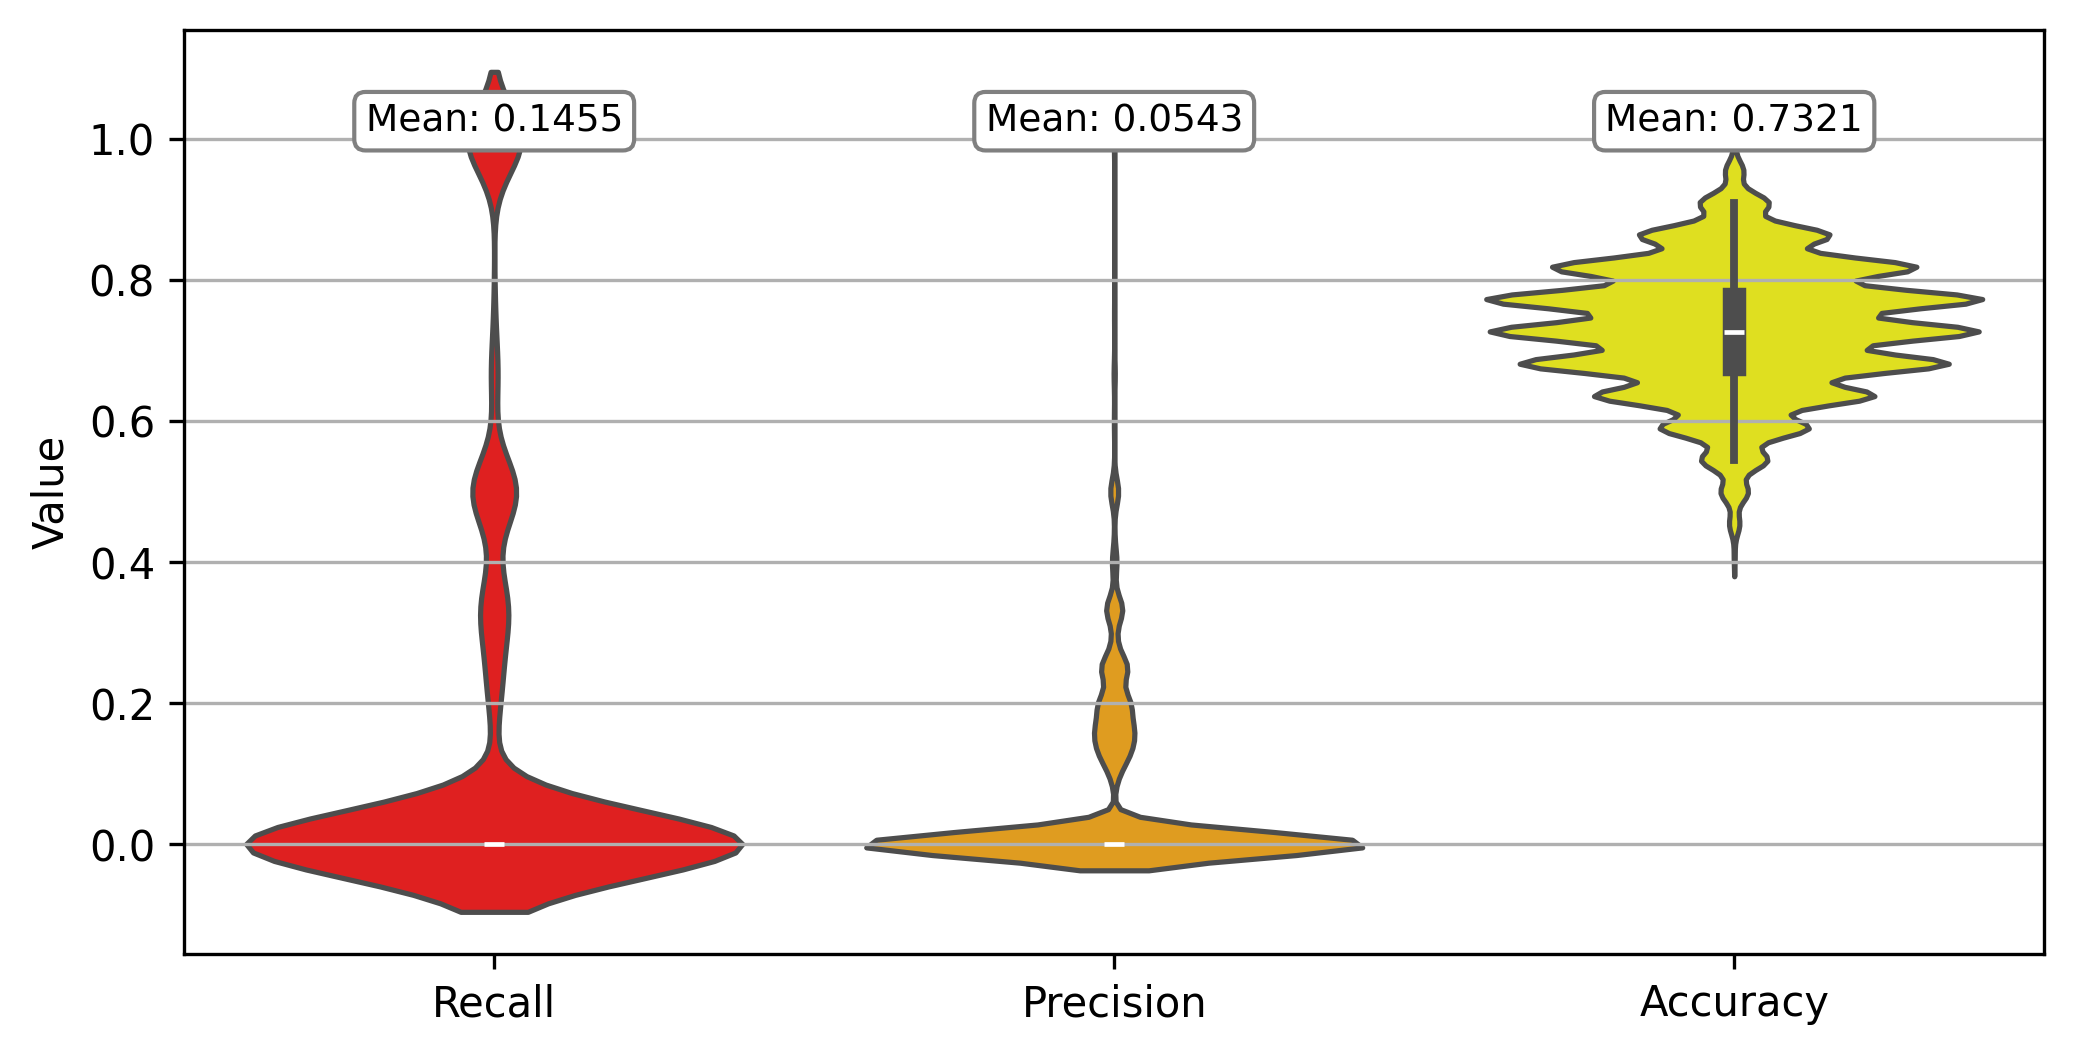

In [40]:

palette = {"Recall": "red", "Precision": "orange", "Accuracy": "yellow"}
# Example lists (replace these with your actual data)
value_list_1 = rec_mdr_B_list
value_list_2 = prec_mdr_mdr_B_list
value_list_3 = acc_mdr_B_list

# Labels for each list (will appear on x-axis)
labels = ["Recall", "Precision", "Accuracy"]

# Combine all data into one DataFrame
df = pd.DataFrame({
    'Value': value_list_1 + value_list_2 + value_list_3,
    'Group': [labels[0]] * len(value_list_1) +
             [labels[1]] * len(value_list_2) +
             [labels[2]] * len(value_list_3)
})

# Calculate means
means = df.groupby('Group')['Value'].mean()

# Create a high-resolution figure
plt.figure(dpi=300, figsize=(8, 4))

# Create the violin plot
ax = sns.violinplot(x='Group', y='Value', data=df, inner='box', palette=palette)

# Add mean as text above each violin
for i, label in enumerate(labels):
    mean_val = means[label]
    ax.text(
        i, df['Value'].max(), f"Mean: {mean_val:.4f}",
        ha='center', va='bottom', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
    )

# Customize plot
plt.grid(True, axis='y')
plt.xlabel('')
plt.ylabel('Value')

# Save the figure
plt.savefig(plot_folder + "mean_metrics_env_mdr_with_weather_without_farmid.png", format='png', dpi=300, bbox_inches='tight')
plt.savefig(plot_folder + "mean_metrics_env_mdr_with_weather_without_farmid.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


# environment data set without weather

In [33]:
data=pd.read_csv(input_folder+"MICenvironment_withoutweather_v7_modified.csv",sep=",")

In [34]:
data

,FarmID,Datum,mdr,Item8_Constantgroup,Item12_Equip_preweaned,Item1_Milk_yield,Item11_Equip_feed_manure,Item10_Wastemilk,Item17_Dogs,Item9_Calfdiet,...,Item2_Milk_SCC,Item3_Stall,Item6_Contact_feces,Item21_Pneumonia30d_weaning,Item15_2_New_animals_nbfarms,nwt,Item24_AMU_systemic,Item25_AMU_calves,Item5_Calfmovedafterbirth,Item7_Groupsize
0,32,01/04/2022,1,0,0,0,0,0,0.00,0,...,0.00,1,0,0.00,0.00,1,1,1,0,1
1,32,01/04/2022,1,0,0,0,0,0,0.00,0,...,0.00,1,0,0.00,0.00,1,1,1,0,1
2,32,01/04/2022,1,0,0,0,0,0,0.00,0,...,0.00,1,0,0.00,0.00,1,1,1,0,1
3,32,01/04/2022,1,0,0,0,0,0,0.00,0,...,0.00,1,0,0.00,0.00,1,1,1,0,1
4,33,01/04/2022,0,1,0,1,0,0,1.00,1,...,0.00,0,1,0.00,2.00,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,13,02/06/2023,0,0,0,0,0,1,1.00,1,...,0.00,1,1,1.00,3.00,0,1,1,1,1
773,20,02/06/2023,0,1,0,0,0,1,1.00,1,...,0.00,0,1,0.00,2.00,0,1,1,0,0
774,20,02/06/2023,0,1,0,0,0,1,1.00,1,...,0.00,0,1,0.00,2.00,0,1,1,0,0
775,20,02/06/2023,1,1,0,0,0,1,1.00,1,...,0.00,0,1,0.00,2.00,1,1,1,0,0


## model nwt

In [35]:

items_2_remove_A=['Datum', 'mdr','nwt']
items_2_remove_B=['FarmID','Datum', 'mdr','nwt']


df_11_list=[]
df_22_list=[]

acc_A_list=[]
acc_B_list=[]

prec_A_list=[]
prec_B_list=[]

rec_A_list=[]
rec_B_list=[]
for i in range(10000):
    print(i)
    with HiddenPrints():
        df_A,df_B,acc_A,acc_B,prec_A,prec_B,rec_A,rec_B=run_two_rf_B(data,group_by='Datum',target="nwt",vars_2_rm_A=items_2_remove_A,vars_2_rm_B=items_2_remove_B,trainvalsplit=.2)
    df_11_list.append(df_A)
    df_22_list.append(df_B)
    acc_A_list.append(acc_A)
    acc_B_list.append(acc_B)
    prec_A_list.append(prec_A)
    prec_B_list.append(prec_B)
    rec_A_list.append(rec_A)
    rec_B_list.append(rec_B)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [36]:
print(np.mean(acc_A_list))

0.5553318181818182


In [37]:
print(np.std(acc_A_list))

0.10326969335732386


In [38]:
print(np.mean(acc_B_list))

0.55755


In [39]:
print(np.std(acc_B_list))

0.10553964816461509


### plot importances

In [40]:
all_importances = pd.concat(df_11_list, axis=1)
mean_importances = all_importances_11.mean(axis=1)
mean_importances_df = mean_importances_11.reset_index()
mean_importances_df.columns = ['Feature', 'Mean Importance']
mean_importances_df.to_csv(output_folder+"mean_importances_env_nwt_without_weather_with_farmid.csv")



,Feature,Mean Importance
0,FarmID,0.16
7,Item24_AMU_systemic,0.10
4,Item25_AMU_calves,0.09
1,Item15_2_New_animals_nbfarms,0.07
9,Item7_Groupsize,0.06
11,Item2_Milk_SCC,0.05
10,Item5_Calfmovedafterbirth,0.04
17,Item10_Wastemilk,0.04
12,Item9_Calfdiet,0.04
8,Item17_Dogs,0.04


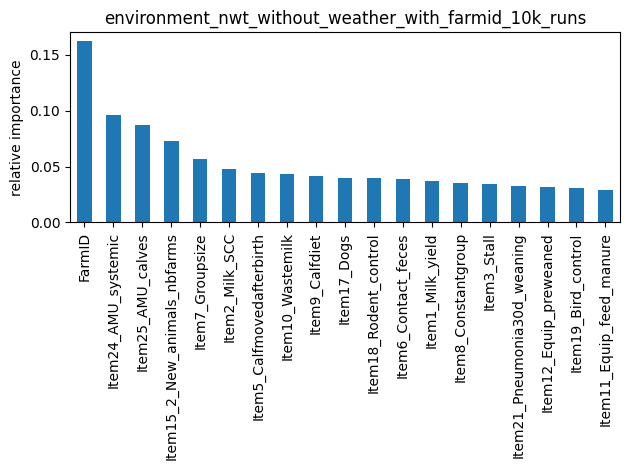

In [41]:
plot_importance(mean_importances=mean_importances_df,title="environment_nwt_without_weather_with_farmid_10k_runs",plot_folder=plot_folder)

In [42]:
all_importances_22 = pd.concat(df_22_list, axis=1)
mean_importances_22 = all_importances_22.mean(axis=1)
mean_importances_df_22 = mean_importances_22.reset_index()
mean_importances_df_22.columns = ['Feature', 'Mean Importance']
mean_importances_df_22.to_csv(output_folder+"mean_importances_env_nwt_without_weather_without_farmid.csv")
mean_importances_df_22.sort_values(by=['Mean Importance'], ascending=False).head(10)


,Feature,Mean Importance
4,Item24_AMU_systemic,0.10
1,Item25_AMU_calves,0.09
0,Item15_2_New_animals_nbfarms,0.09
2,Item7_Groupsize,0.07
11,Item2_Milk_SCC,0.06
14,Item5_Calfmovedafterbirth,0.05
15,Item10_Wastemilk,0.05
13,Item9_Calfdiet,0.05
5,Item6_Contact_feces,0.05
7,Item17_Dogs,0.05


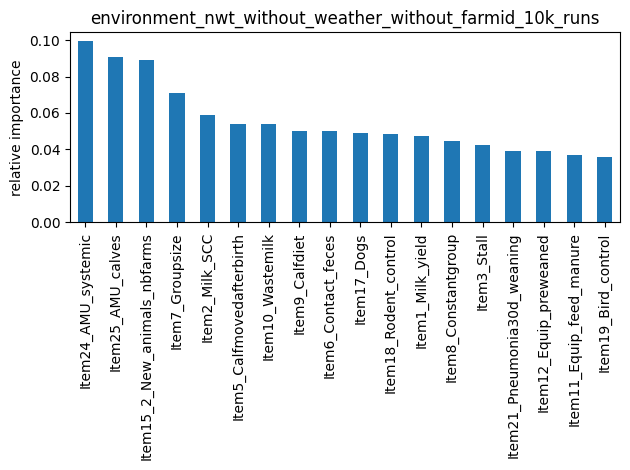

In [43]:
plot_importance(mean_importances=mean_importances_df,title="environment_nwt_without_weather_without_farmid_10k_runs",plot_folder=plot_folder)


### plot skill metrics

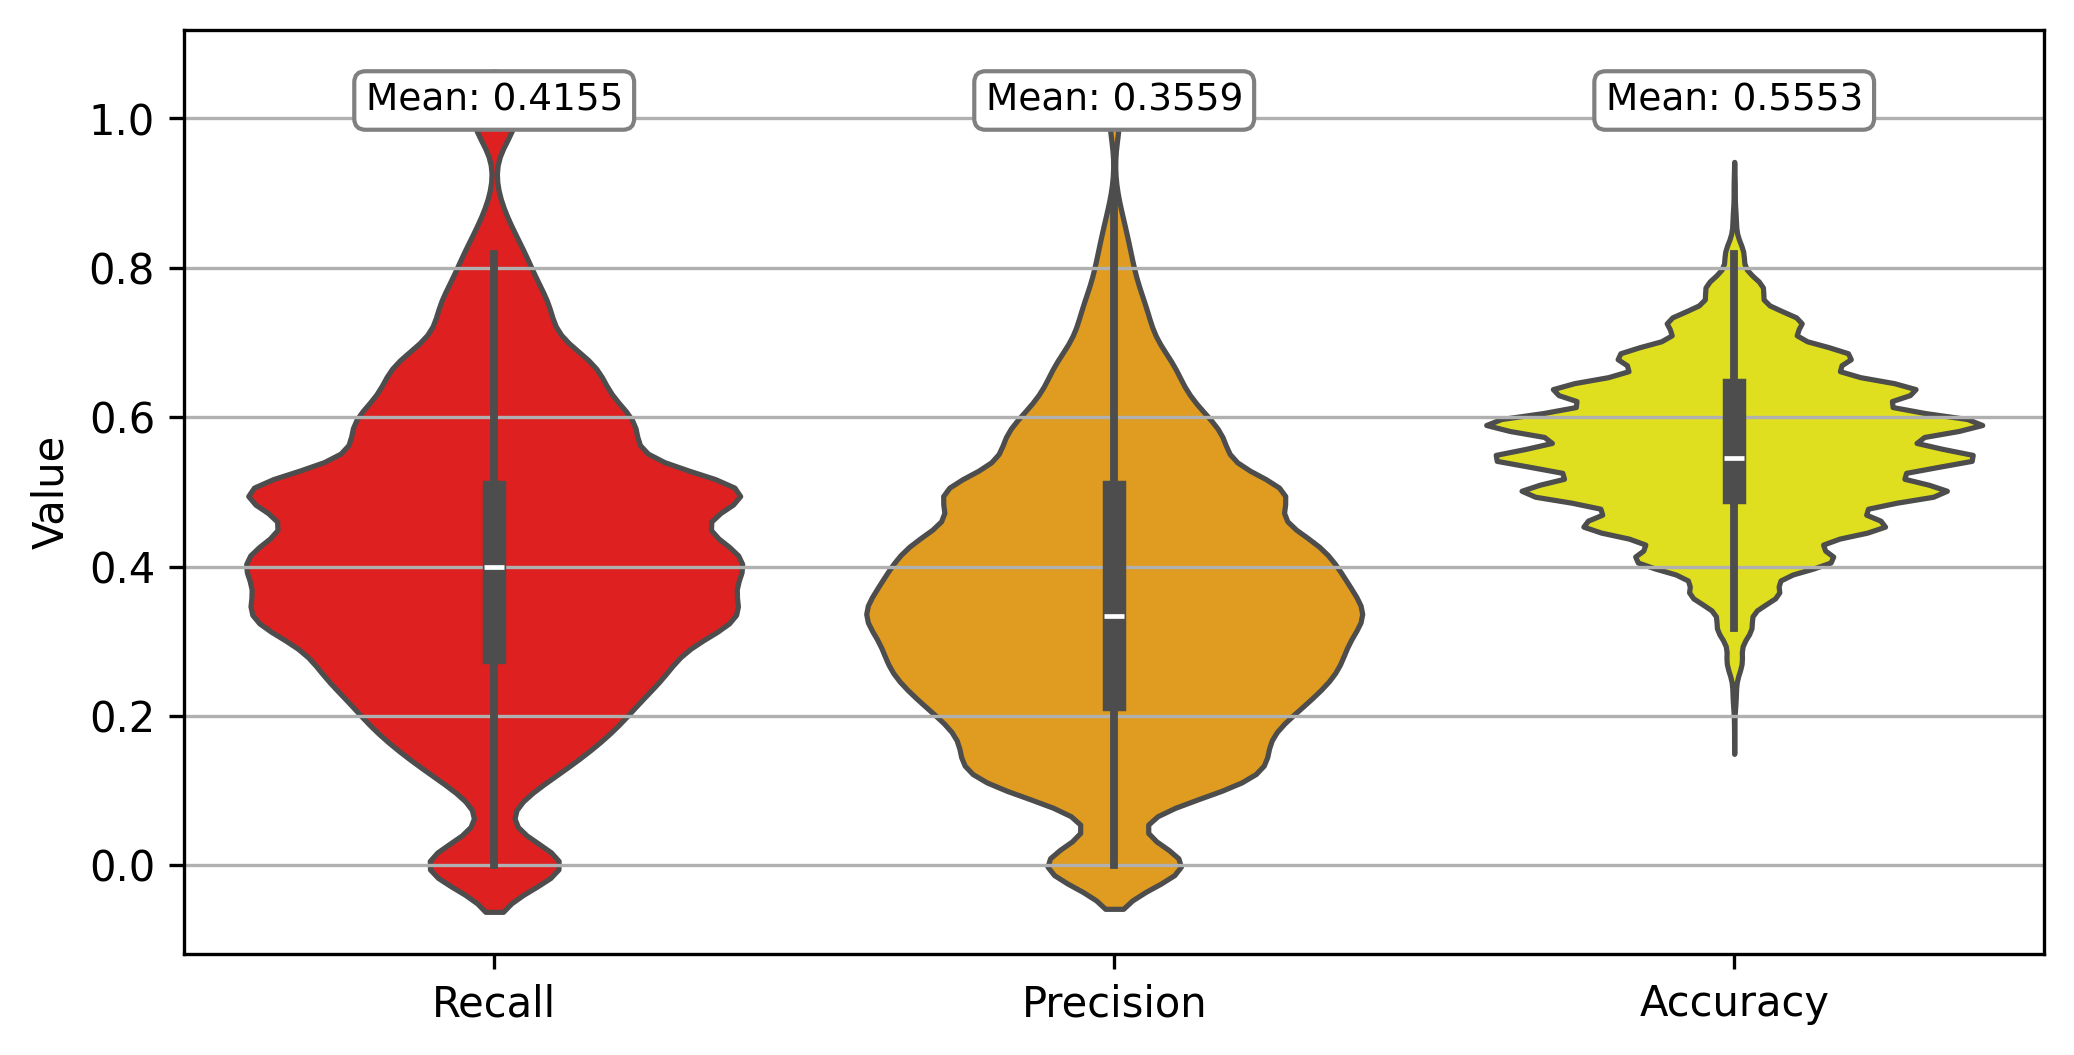

In [44]:

palette = {"Recall": "red", "Precision": "orange", "Accuracy": "yellow"}
# Example lists (replace these with your actual data)
value_list_1 = rec_A_list
value_list_2 = prec_A_list
value_list_3 = acc_A_list

# Labels for each list (will appear on x-axis)
labels = ["Recall", "Precision", "Accuracy"]

# Combine all data into one DataFrame
df = pd.DataFrame({
    'Value': value_list_1 + value_list_2 + value_list_3,
    'Group': [labels[0]] * len(value_list_1) +
             [labels[1]] * len(value_list_2) +
             [labels[2]] * len(value_list_3)
})

# Calculate means
means = df.groupby('Group')['Value'].mean()

# Create a high-resolution figure
plt.figure(dpi=300, figsize=(8, 4))

# Create the violin plot
ax = sns.violinplot(x='Group', y='Value', data=df, inner='box', palette=palette)

# Add mean as text above each violin
for i, label in enumerate(labels):
    mean_val = means[label]
    ax.text(
        i, df['Value'].max(), f"Mean: {mean_val:.4f}",
        ha='center', va='bottom', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
    )

# Customize plot
plt.grid(True, axis='y')
plt.xlabel('')
plt.ylabel('Value')

# Save the figure
plt.savefig(plot_folder + "mean_metrics_env_nwt_without_weather_with_farmid.png", format='png', dpi=300, bbox_inches='tight')
plt.savefig(plot_folder + "mean_metrics_env_nwt_without_weather_with_farmid.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


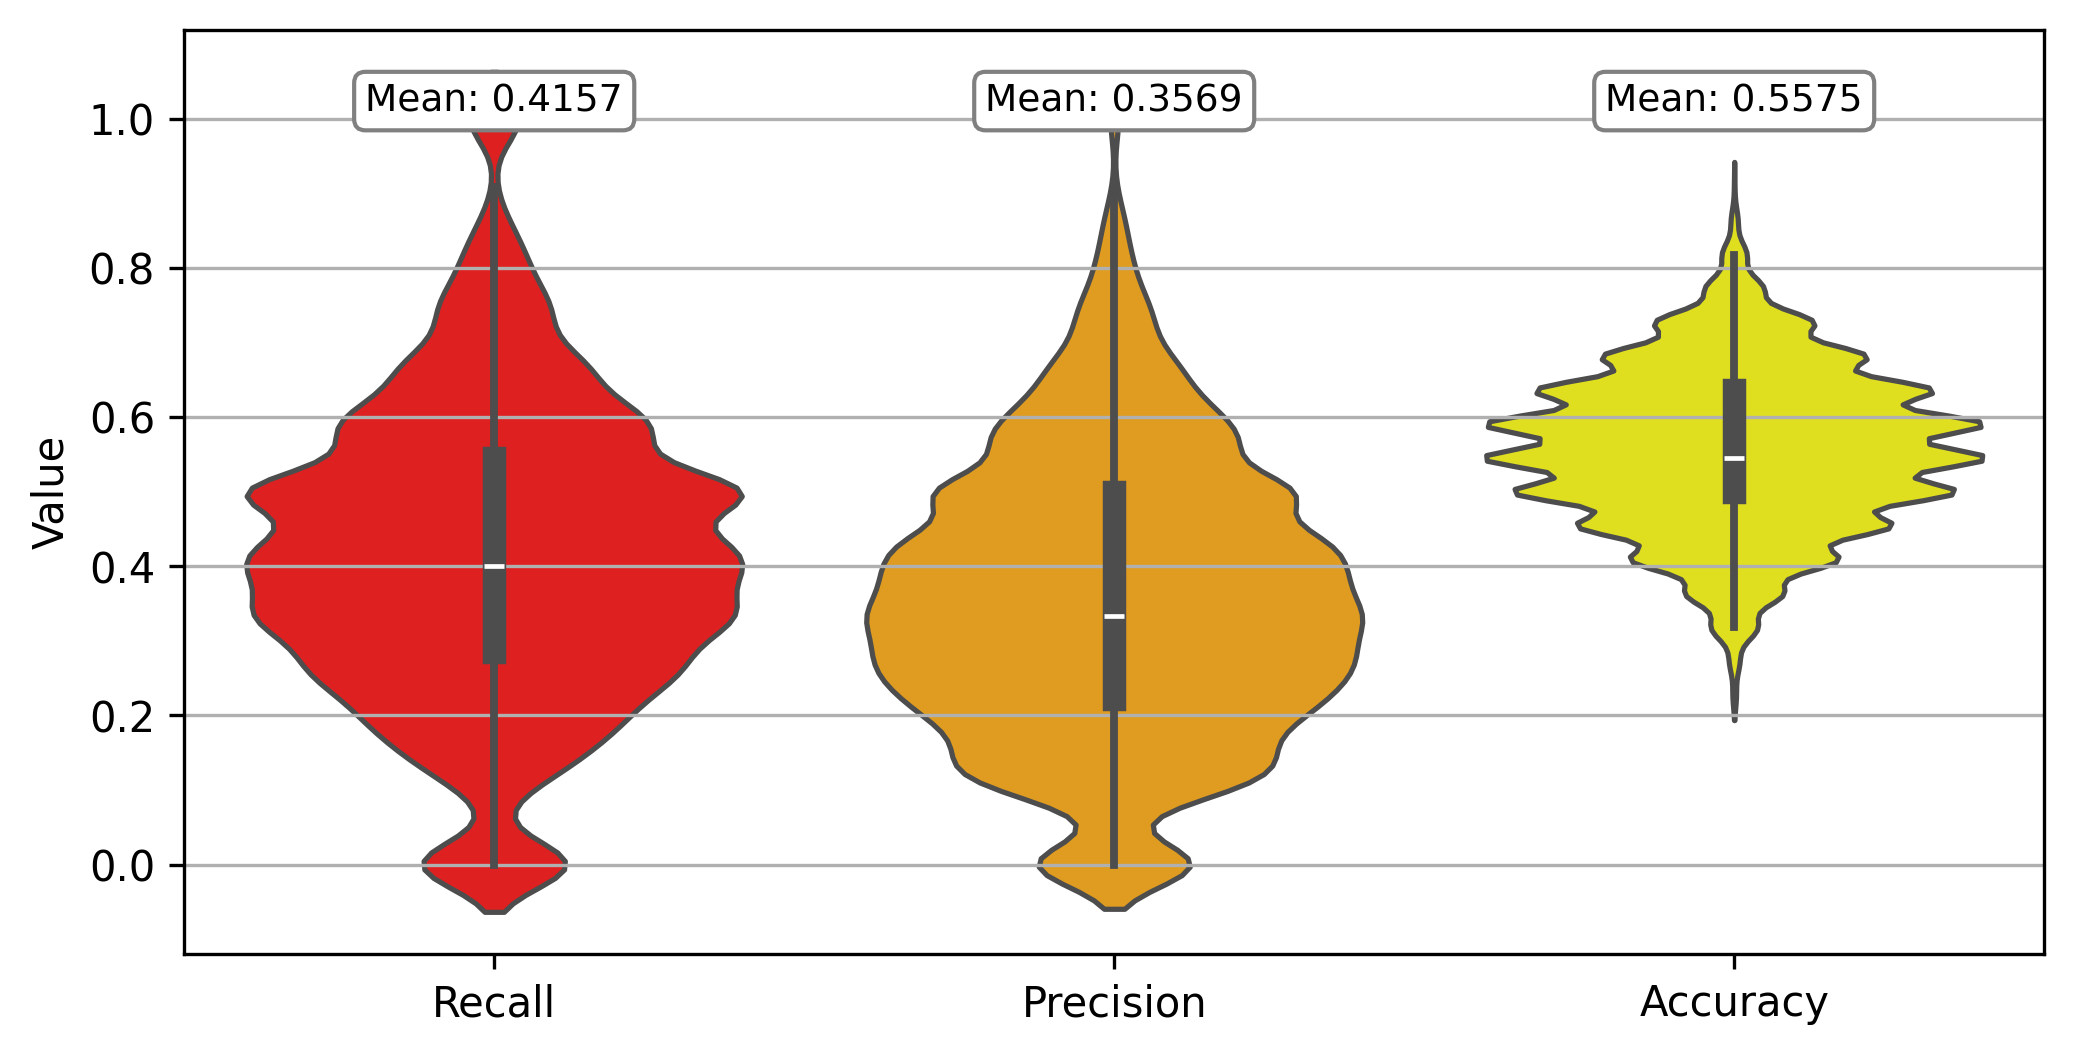

In [45]:

palette = {"Recall": "red", "Precision": "orange", "Accuracy": "yellow"}
# Example lists (replace these with your actual data)
value_list_1 = rec_B_list
value_list_2 = prec_B_list
value_list_3 = acc_B_list

# Labels for each list (will appear on x-axis)
labels = ["Recall", "Precision", "Accuracy"]

# Combine all data into one DataFrame
df = pd.DataFrame({
    'Value': value_list_1 + value_list_2 + value_list_3,
    'Group': [labels[0]] * len(value_list_1) +
             [labels[1]] * len(value_list_2) +
             [labels[2]] * len(value_list_3)
})

# Calculate means
means = df.groupby('Group')['Value'].mean()

# Create a high-resolution figure
plt.figure(dpi=300, figsize=(8, 4))

# Create the violin plot
ax = sns.violinplot(x='Group', y='Value', data=df, inner='box', palette=palette)

# Add mean as text above each violin
for i, label in enumerate(labels):
    mean_val = means[label]
    ax.text(
        i, df['Value'].max(), f"Mean: {mean_val:.4f}",
        ha='center', va='bottom', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
    )

# Customize plot
plt.grid(True, axis='y')
plt.xlabel('')
plt.ylabel('Value')

# Save the figure
plt.savefig(plot_folder + "mean_metrics_env_nwt_without_weather_without_farmid.png", format='png', dpi=300, bbox_inches='tight')
plt.savefig(plot_folder + "mean_metrics_env_nwt_without_weather_without_farmid.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


## model mdr

In [54]:

items_2_remove_A=['Datum', 'mdr','nwt']
items_2_remove_B=['FarmID','Datum', 'mdr','nwt']


df_mdr_A_list=[]
df_mdr_B_list=[]

acc_mdr_A_list=[]
acc_mdr_B_list=[]

prec_mdr_mdr_A_list=[]
prec_mdr_mdr_B_list=[]

rec_mdr_A_list=[]
rec_mdr_B_list=[]
for i in range(10000):
    print(i)
    with HiddenPrints():
        df_A,df_B,acc_mdr_A,acc_mdr_B,prec_mdr_mdr_A,prec_mdr_mdr_B,rec_mdr_A,rec_mdr_B=run_two_rf_B(data,group_by='Datum',target="mdr",vars_2_rm_A=items_2_remove_A,vars_2_rm_B=items_2_remove_B,trainvalsplit=.2)
    df_mdr_A_list.append(df_A)
    df_mdr_B_list.append(df_B)
    acc_mdr_A_list.append(acc_mdr_A)
    acc_mdr_B_list.append(acc_mdr_B)
    prec_mdr_mdr_A_list.append(prec_mdr_mdr_A)
    prec_mdr_mdr_B_list.append(prec_mdr_mdr_B)
    rec_mdr_A_list.append(rec_mdr_A)
    rec_mdr_B_list.append(rec_mdr_B)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [55]:
print(np.mean(acc_mdr_A_list))

0.6835681818181818


In [56]:
print(np.mean(acc_mdr_B_list))

0.6861909090909092


### plot importances

In [57]:
all_importances_mdr = pd.concat(df_mdr_A_list, axis=1)
mean_importances_mdr = all_importances_mdr_A.mean(axis=1)
mean_importances_df_mdr = mean_importances_mdr_A.reset_index()
mean_importances_df_mdr.columns = ['Feature', 'Mean Importance']
mean_importances_df_mdr.to_csv(output_folder+"mean_importances_env_mdr_without_weather_with_farmid.csv")



,Feature,Mean Importance
0,FarmID,0.16
2,Item24_AMU_systemic,0.09
3,Item25_AMU_calves,0.09
5,Item15_2_New_animals_nbfarms,0.07
8,Item2_Milk_SCC,0.06
4,Item7_Groupsize,0.05
11,Item17_Dogs,0.05
7,Item5_Calfmovedafterbirth,0.04
1,Item6_Contact_feces,0.04
16,Item1_Milk_yield,0.04


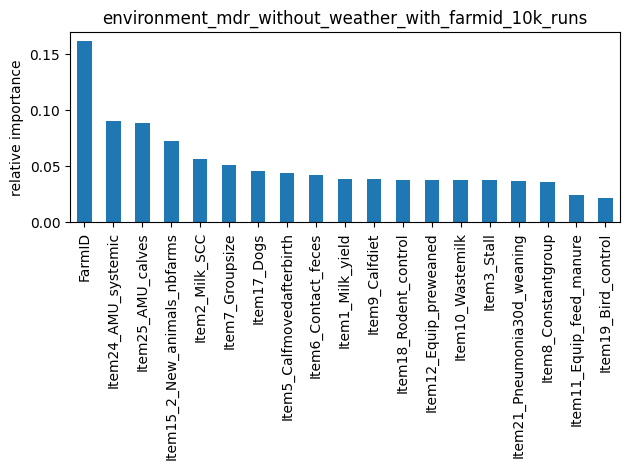

In [58]:
plot_importance(mean_importances=mean_importances_df_mdr,title="environment_mdr_without_weather_with_farmid_10k_runs",plot_folder=plot_folder)

In [59]:
all_importances_mdr= pd.concat(df_mdr_B_list, axis=1)
mean_importances_mdr = all_importances_mdr_B.mean(axis=1)
mean_importances_df_mdr = mean_importances_mdr_B.reset_index()
mean_importances_df_mdr.columns = ['Feature', 'Mean Importance']
mean_importances_df_mdr.to_csv(output_folder+"mean_importances_env_mdr_without_weather_without_farmid.csv")


,Feature,Mean Importance
1,Item24_AMU_systemic,0.09
3,Item25_AMU_calves,0.09
0,Item15_2_New_animals_nbfarms,0.09
6,Item2_Milk_SCC,0.07
5,Item7_Groupsize,0.07
8,Item17_Dogs,0.06
2,Item5_Calfmovedafterbirth,0.05
4,Item6_Contact_feces,0.05
12,Item1_Milk_yield,0.05
7,Item10_Wastemilk,0.05


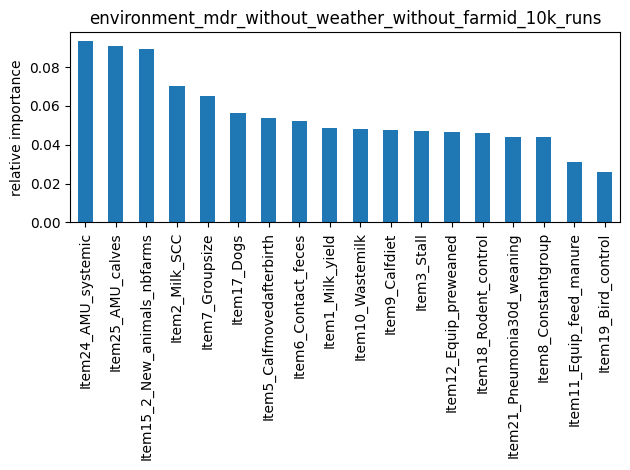

In [60]:
plot_importance(mean_importances=mean_importances_df_mdr_B,title="environment_mdr_without_weather_without_farmid_10k_runs",plot_folder=plot_folder)


### plot skill metrics

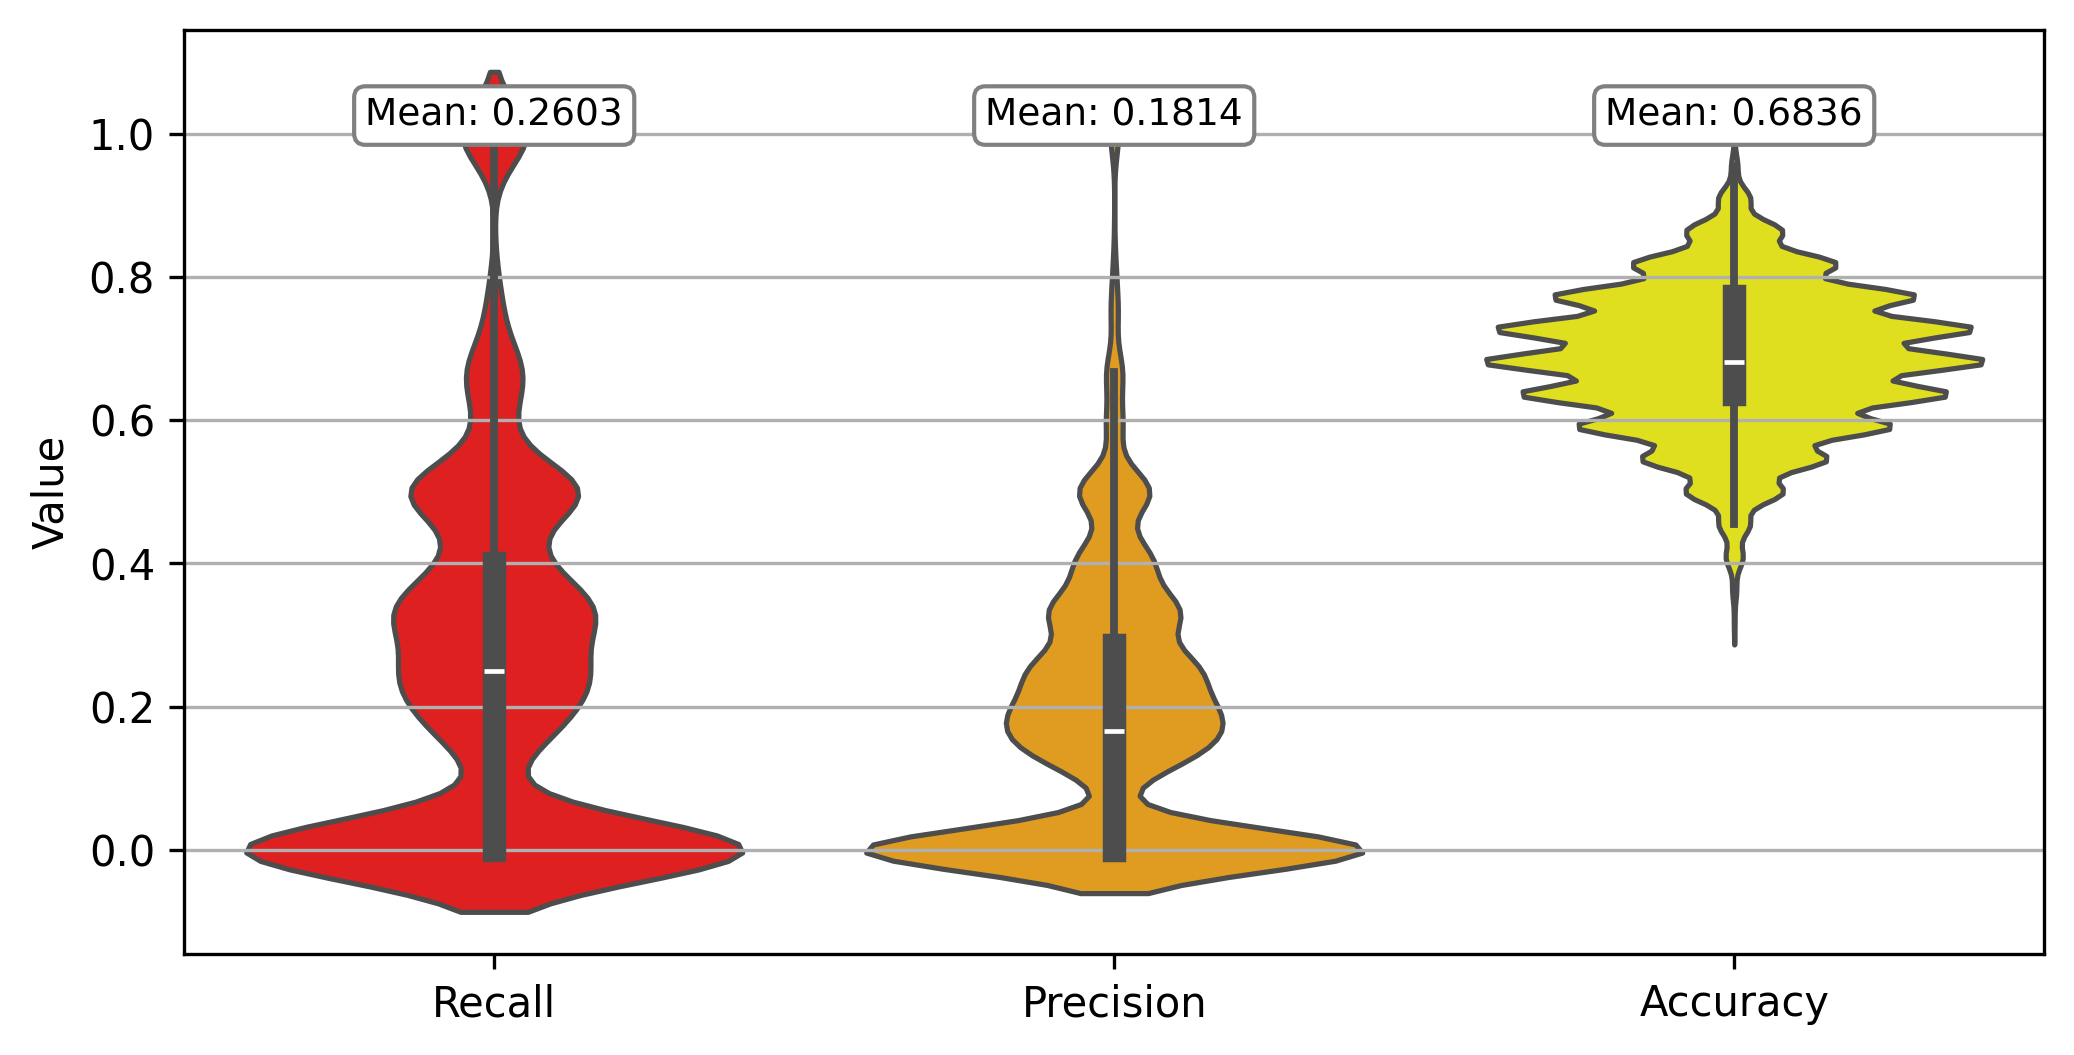

In [61]:

palette = {"Recall": "red", "Precision": "orange", "Accuracy": "yellow"}
# Example lists (replace these with your actual data)
value_list_1 = rec_mdr_A_list
value_list_2 = prec_mdr_mdr_A_list
value_list_3 = acc_mdr_A_list

# Labels for each list (will appear on x-axis)
labels = ["Recall", "Precision", "Accuracy"]

# Combine all data into one DataFrame
df = pd.DataFrame({
    'Value': value_list_1 + value_list_2 + value_list_3,
    'Group': [labels[0]] * len(value_list_1) +
             [labels[1]] * len(value_list_2) +
             [labels[2]] * len(value_list_3)
})

# Calculate means
means = df.groupby('Group')['Value'].mean()

# Create a high-resolution figure
plt.figure(dpi=300, figsize=(8, 4))

# Create the violin plot
ax = sns.violinplot(x='Group', y='Value', data=df, inner='box', palette=palette)

# Add mean as text above each violin
for i, label in enumerate(labels):
    mean_val = means[label]
    ax.text(
        i, df['Value'].max(), f"Mean: {mean_val:.4f}",
        ha='center', va='bottom', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
    )

# Customize plot
plt.grid(True, axis='y')
plt.xlabel('')
plt.ylabel('Value')

# Save the figure
plt.savefig(plot_folder + "mean_metrics_env_mdr_without_weather_with_farmid.png", format='png', dpi=300, bbox_inches='tight')
plt.savefig(plot_folder + "mean_metrics_env_mdr_without_weather_with_farmid.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


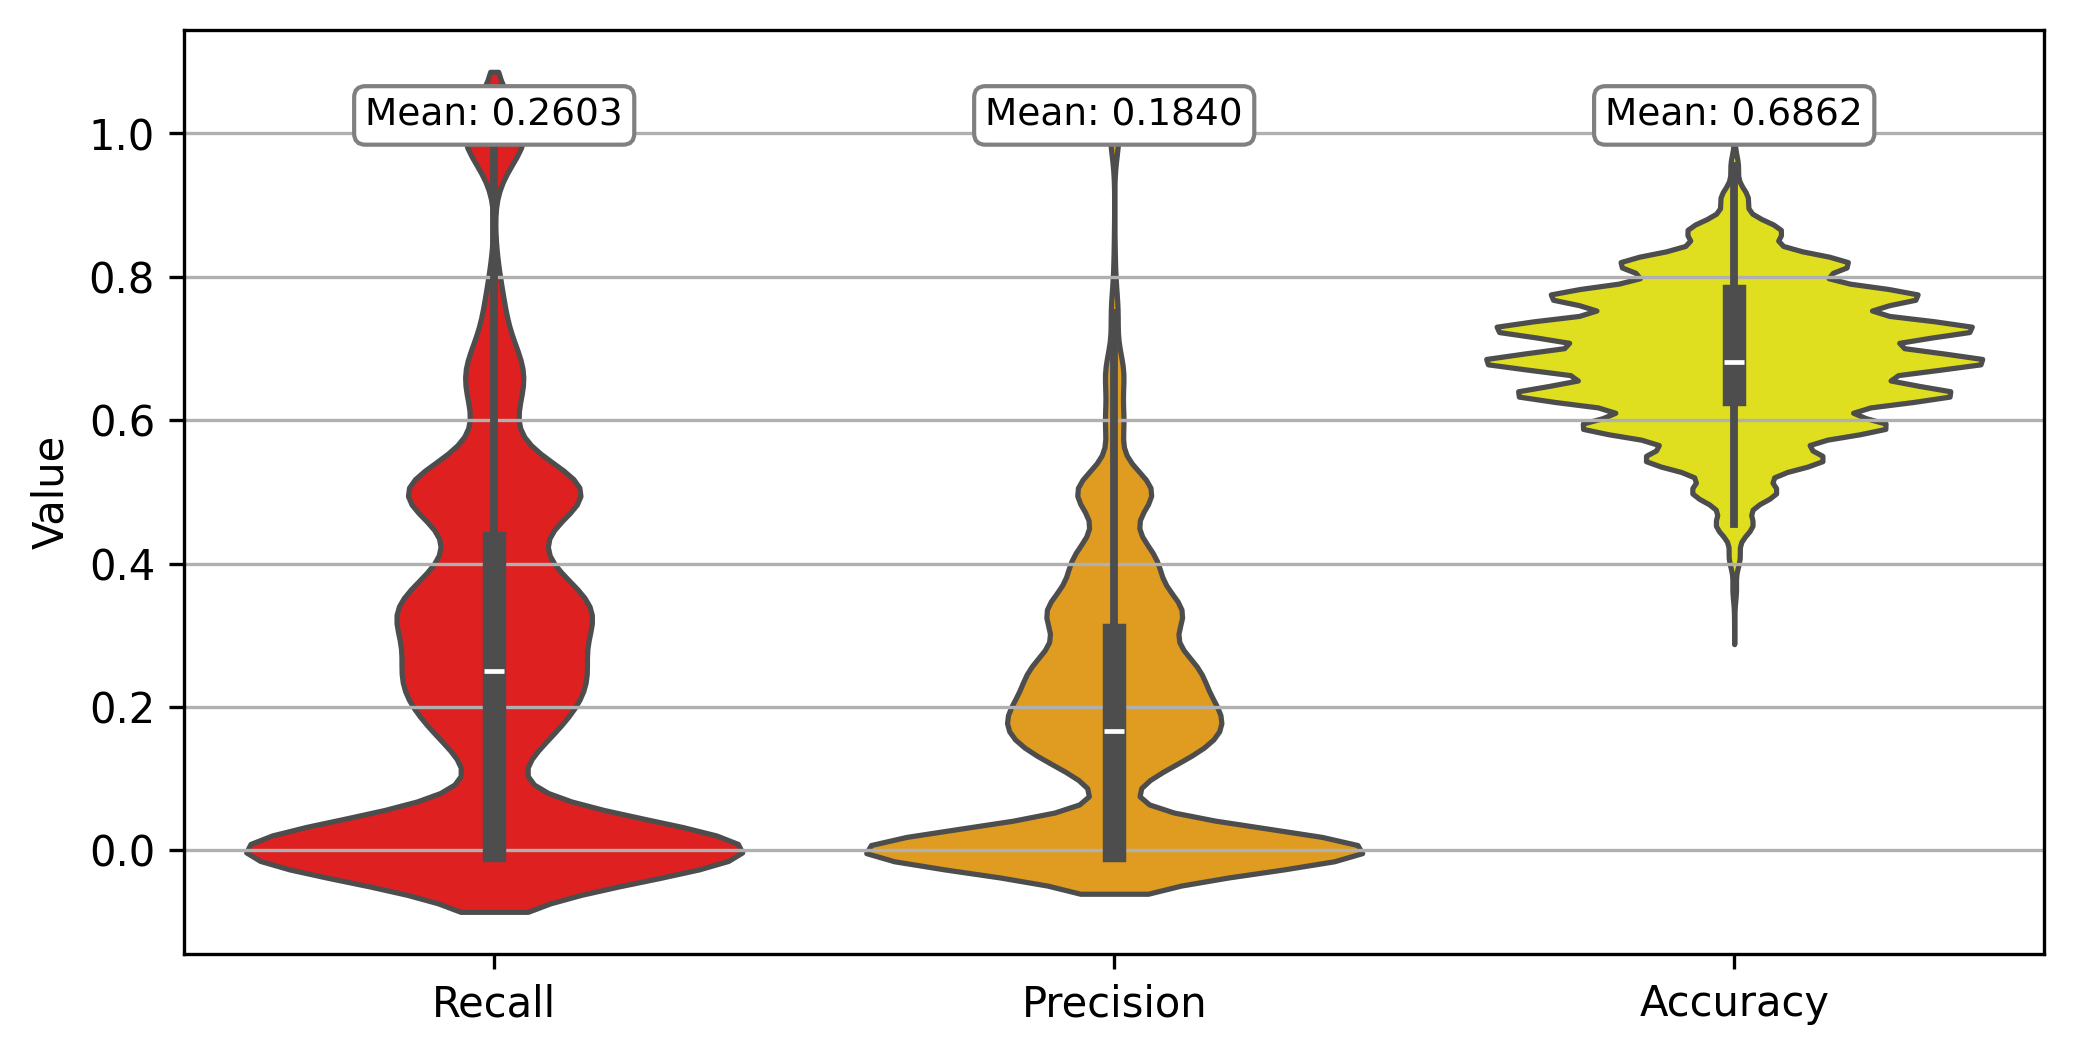

In [62]:

palette = {"Recall": "red", "Precision": "orange", "Accuracy": "yellow"}
# Example lists (replace these with your actual data)
value_list_1 = rec_mdr_B_list
value_list_2 = prec_mdr_mdr_B_list
value_list_3 = acc_mdr_B_list

# Labels for each list (will appear on x-axis)
labels = ["Recall", "Precision", "Accuracy"]

# Combine all data into one DataFrame
df = pd.DataFrame({
    'Value': value_list_1 + value_list_2 + value_list_3,
    'Group': [labels[0]] * len(value_list_1) +
             [labels[1]] * len(value_list_2) +
             [labels[2]] * len(value_list_3)
})

# Calculate means
means = df.groupby('Group')['Value'].mean()

# Create a high-resolution figure
plt.figure(dpi=300, figsize=(8, 4))

# Create the violin plot
ax = sns.violinplot(x='Group', y='Value', data=df, inner='box', palette=palette)

# Add mean as text above each violin
for i, label in enumerate(labels):
    mean_val = means[label]
    ax.text(
        i, df['Value'].max(), f"Mean: {mean_val:.4f}",
        ha='center', va='bottom', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
    )

# Customize plot
plt.grid(True, axis='y')
plt.xlabel('')
plt.ylabel('Value')

# Save the figure
plt.savefig(plot_folder + "mean_metrics_env_mdr_without_weather_without_farmid.png", format='png', dpi=300, bbox_inches='tight')
plt.savefig(plot_folder + "mean_metrics_env_mdr_without_weather_without_farmid.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()
